## In this notebook I am gonna using trained neural networks manually fine tunes their results to get wonderful results of segmenting

In [1]:
%run dataset_loader.py
%run UNET.py
%run sift.py

In [2]:
import os
import torch
import random

import matplotlib.pyplot as plt
from scipy import misc
from PIL import Image

IMG_PATH_TRAIN = "./BBBC018_v1_images-fixed/train/"
OUTLINE_PATH_TRAIN = "./BBBC018_v1_outlines/train/"

IMG_PATH_TEST = "./BBBC018_v1_images-fixed/val/"
OUTLINE_PATH_TEST = "./BBBC018_v1_outlines/val/"

In [3]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), # Real Image are heavy
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
])

/home/boyarintsev.artem/catboost/venv/lib/python3.6/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


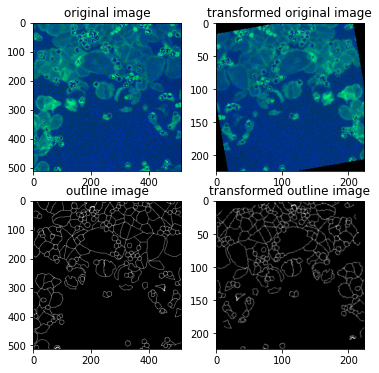

In [4]:
Test = get_dataset(transform_train, IMG_PATH_TEST, OUTLINE_PATH_TEST, show_examples_amount=1)

In [5]:
from sklearn.model_selection import train_test_split
Test, Val = train_test_split(Test, test_size=0.2)

In [6]:
net = UNET().double()  # .cuda()
net.load_state_dict(torch.load("./UNET_weights_segmentation_loss.save"))

<All keys matched successfully>

### Let's ensure that we correctly loaded weights and dataset

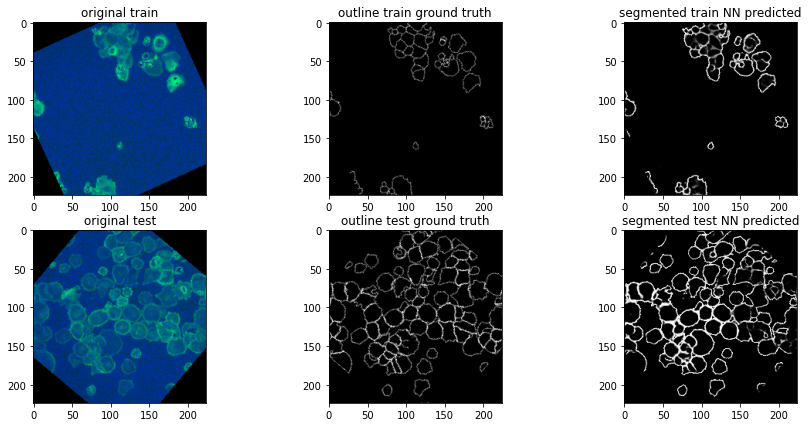

In [7]:
sift(net, Test, Test)

In [8]:
def calc_recall(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += (ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union


def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union


def calc_dice(prediction, ground_truth):
    n_images = len(prediction)
    intersection, dice_denumerator = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        dice_denumerator += np.sum(prediction[i] > 0) + np.sum(ground_truth[i] > 0)
        
    return float(2*intersection) / dice_denumerator

In [9]:
def segmentate(Test, net):
    test_images = Test[:,:3,:,:]
    net_segmented_images = []
    
    for i in range(test_images.shape[0]):
        img = Test[i:i+1,:3]
        net_segmented = net(img)
        net_segmented_numpy = net_segmented.detach().cpu().numpy()
        net_segmented_numpy = net_segmented_numpy[0].transpose(1,2,0)[:,:,-1]
        
        net_segmented_images.append(net_segmented_numpy)
   
    return net_segmented_images


net_segmented_images_test = np.array(segmentate(Test, net))
net_segmented_images_val = np.array(segmentate(Val, net))

In [10]:
import pandas as pd

def find_optimal_threshold(net_segmented, ground_truth_segmented, begin, end, step):
    df = pd.DataFrame(columns=['iou', 'dice'])
    for x in np.arange(begin, end, step):
        net_segmented_thres = net_segmented > x 
        iou = calc_iou(net_segmented_thres, ground_truth_segmented)
        dice = calc_dice(net_segmented_thres, ground_truth_segmented)
        df.loc[x] = (iou, dice)
        #print(calc_iou(net_segmented_thres, ground_truth_segmented))
    return df

In [11]:
df=find_optimal_threshold(net_segmented_images_test, Test[:,3].numpy(), 0, 1, 0.02)

In [12]:
df

,iou,dice
0.00,0.200446,0.333953
0.02,0.551451,0.710885
0.04,0.524289,0.687913
0.06,0.503432,0.669710
0.08,0.486434,0.654498
0.10,0.471872,0.641187
0.12,0.459105,0.629297
0.14,0.447579,0.618383
0.16,0.437092,0.608301
0.18,0.427264,0.598717


In [13]:
df=find_optimal_threshold(net_segmented_images_test, Test[:,3].numpy(), 0.0, 0.05, 0.001)
df

,iou,dice
0.000,0.200446,0.333953
0.001,0.484456,0.652705
0.002,0.528841,0.691819
0.003,0.549681,0.709412
0.004,0.559817,0.717798
0.005,0.564685,0.721787
0.006,0.566962,0.723645
0.007,0.567725,0.724266
0.008,0.567626,0.724185
0.009,0.567048,0.723715


In [14]:
best_thres = df[df['iou'] == max(df['iou'])].index[0]
print(f'Best threshold is {best_thres}')

Best threshold is 0.007


In [15]:
iou_val = calc_iou(net_segmented_images_val > best_thres, Val[:,3].numpy())
dice_val = calc_dice(net_segmented_images_val > best_thres, Val[:,3].numpy())

iou_val, dice_val

(0.5595656530098296, 0.7175916601265427)

In [18]:
index = np.random.choice(len(Val))  # Let's take random image from validation set

0.6530813953488372
0.7901382196743221
0.7242424242424242


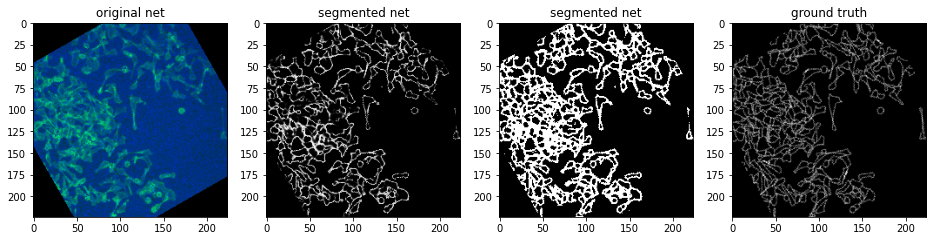

In [19]:
f, ax = plt.subplots(1,4, figsize=(16,8))
ax[0].set_title('original net')
ax[0].imshow(Val[index,:3].detach().numpy().transpose(1,2,0).clip(0,1), 'gray')

ax[1].set_title('segmented net')
ax[1].imshow(net_segmented_images_val[index].clip(0,1), 'gray')

ax[2].set_title('segmented net')
ax[2].imshow(net_segmented_images_val[index].clip(0,1) > best_thres, 'gray')

ax[3].set_title('ground truth')
ax[3].imshow(Val[index,3].numpy().clip(0,1), 'gray')

print(calc_iou(net_segmented_images_val[index:index+1] > best_thres, [Val[index,3].numpy()]))
print(calc_dice(net_segmented_images_val[index:index+1] > best_thres, [Val[index,3].numpy()]))
print(calc_recall(net_segmented_images_val[index:index+1] > best_thres, [Val[index,3].numpy()]))
#print(calc_dice([net_segmented_numpy > thres], [Test[0,3].numpy()]))

## Seems pretty good to me. Because ground truth images are not actually segmented images, but just borders of cells. Therefore we could not expect good metrics results for it.